In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

In [39]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [40]:
data_path='./data'

train_data=datasets.EMNIST(root=data_path,train=True,download=False,split='letters')
test_data=datasets.EMNIST(root=data_path,train=False,download=False,split='letters')

In [41]:
train_data.data.shape,test_data.data.shape


(torch.Size([124800, 28, 28]), torch.Size([20800, 28, 28]))

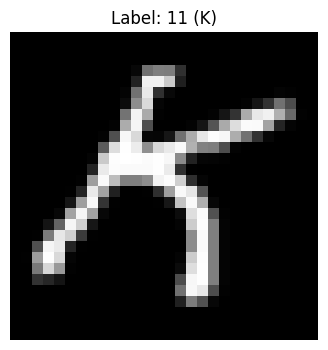

In [42]:
idx = 7
image, label = train_data[idx]
letter = chr(label + 64) 
plt.figure(figsize=(4, 4))

image_rotated = F.rotate(image,90)
image_flipped=F.vflip(image_rotated)

plt.imshow(image_flipped, cmap='gray')
plt.title(f"Label: {label} ({letter})")
plt.axis('off')
plt.show()

In [43]:
raw_data=train_data.data.float() / 255.0
mean =raw_data.mean().item()
std=raw_data.std().item()

print(f"\nCalculated Mean: {mean:.4f}")
print(f"Calculated Std:  {std:.4f}")


Calculated Mean: 0.1722
Calculated Std:  0.3309


In [ ]:
mean=(0.1722,)
std=(0.3309,)

train_transform=transforms.Compose([
    lambda img: transforms.functional.rotate(img, -90),
    lambda img: transforms.functional.hflip(img),
    transforms.RandomAffine(degrees=15,translate=(0.1,0.1),scale=(0.9,1.1),shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

test_transform=transforms.Compose([
    lambda img: transforms.functional.rotate(img, -90),
    lambda img: transforms.functional.hflip(img),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

train_data.transform=train_transform
test_data.transform=test_transform

In [45]:
image, label = train_data[7]
print(image)

tensor([[[-0.5204, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204,
          -0.5204, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204,
          -0.5204, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204,
          -0.5204, -0.5204, -0.5204, -0.5204, -0.4967, -0.5204, -0.5204],
         [-0.5204, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204,
          -0.5204, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204,  0.9847,
           0.9610,  0.0603, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204,
          -0.5204, -0.5204, -0.5204, -0.4730, -0.4967, -0.5204, -0.5204],
         [-0.5204, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204,
          -0.5204, -0.5204, -0.5204, -0.5204, -0.4374,  0.8188,  2.3357,
           1.8735, -0.1530, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204,
          -0.4848, -0.2715,  0.0722,  0.8306,  0.3803, -0.4967, -0.5204],
         [-0.5204, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204, -0.5204,
          -0.5204, -0.5204, -0.5204, -0.5204, -0

In [ ]:
train_dataloader=DataLoader(train_data,batch_size=64,shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=64,shuffle=False)

print(f'Number of training samples: {len(train_data)}')
print(f'Number of test samples: {len(test_data)}')
print(50*'=')
print('Train Loader: \n')
print(f'Number of training batches: {len(train_dataloader)}')

for batch_num,(data,labels) in enumerate(train_dataloader):
    print(f'Batch {batch_num+1}:')
    print(f' - data shape: {data.shape}')
    print(f' - labels shape: {labels.shape}\n\n')
    break 

print('Test Loader: \n')
print(f'Number of test batches: {len(test_dataloader)}')
for batch_num,(data,labels) in enumerate(test_dataloader):
    print(f'Batch {batch_num+1}:')
    print(f' - data shape: {data.shape}')
    print(f' - labels shape: {labels.shape}\n\n')
    break

In [47]:
torch.manual_seed(42)

model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,512),
    nn.ReLU(),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Linear(256,26)
)
loss_function=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

print(f'Model architecture:\n{model}')
print(f'Loss function: {loss_function}')
print(f'Optimizer: {optimizer}')

Model architecture:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=26, bias=True)
)
Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [48]:
def evaluate(model,test_dataloader,device,verbose=True):
    model.eval()
    num_correct_predictions = 0
   
    total_predictions = 0 
    with torch.no_grad():
        
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets - 1
            outputs = model(inputs)
            predicted_indices = torch.argmax(outputs,dim=1)
            correct_predictions = (predicted_indices==targets).sum().item()        
            num_correct_predictions += correct_predictions
            batch_size = len(targets)
            total_predictions +=batch_size 
        accuracy_percentage = (num_correct_predictions / total_predictions) * 100
        if verbose:
            print((f'Test Accuracy: {accuracy_percentage:.2f}%'))

    return accuracy_percentage

In [50]:
from sklearn.metrics import accuracy_score
def evaluate_per_class(model, test_loader, device):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            labels = labels - 1

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    class_accuracies = {}

    for class_idx in range(26):  
        class_targets = [
            t for t, p in zip(all_targets, all_predictions) if t == class_idx
        ]
        class_predictions = [
            p for t, p in zip(all_targets, all_predictions) if t == class_idx
        ]

        if len(class_targets) > 0:
            class_accuracies[chr(65 + class_idx)] = accuracy_score(
                class_targets, class_predictions
            )
        else:
            class_accuracies[chr(65 + class_idx)] = 0.0  

    return class_accuracies

In [ ]:
model.to(device)
best_test_accuracy=0.0

for epoch in range(50):
    model.train()
    running_loss=0.0
    num_correct_predictions=0
    total_predictions=0

    for batch_num,(data,labels) in enumerate(train_dataloader):
        data,labels=data.to(device),labels.to(device)
        labels=labels-1

        optimizer.zero_grad()
        outputs=model(data)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        predicted_indices=torch.argmax(outputs,dim=1)
        num_correct_predictions+=(predicted_indices==labels).sum().item()
        total_predictions+=len(labels)

    average_loss=running_loss/len(train_dataloader)
    train_accuracy=(num_correct_predictions/total_predictions)*100
    test_accuracy=evaluate(model,test_dataloader,device,verbose=False)

    if test_accuracy>best_test_accuracy:
        best_test_accuracy=test_accuracy
        torch.save(model.state_dict(),'mlp_model.pth')
        print(f"Epoch {epoch+1}/50 | Train Loss: {average_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Test Acc: {test_accuracy:.2f}% | *saved*")
    else:
        print(f"Epoch {epoch+1}/50 | Train Loss: {average_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Test Acc: {test_accuracy:.2f}%")

print(f"\nBest Test Accuracy: {best_test_accuracy:.2f}%")

In [52]:
class_accuracies=evaluate_per_class(model,test_dataloader,device)

for letter, accuracy in class_accuracies.items():
    print(f"Accuracy for {letter}: {(accuracy*100):.2f} %")

Accuracy for A: 82.88 %
Accuracy for B: 94.25 %
Accuracy for C: 95.50 %
Accuracy for D: 93.25 %
Accuracy for E: 95.12 %
Accuracy for F: 94.25 %
Accuracy for G: 77.75 %
Accuracy for H: 91.88 %
Accuracy for I: 64.00 %
Accuracy for J: 94.88 %
Accuracy for K: 94.50 %
Accuracy for L: 78.25 %
Accuracy for M: 97.00 %
Accuracy for N: 93.88 %
Accuracy for O: 96.88 %
Accuracy for P: 97.12 %
Accuracy for Q: 82.88 %
Accuracy for R: 94.88 %
Accuracy for S: 97.75 %
Accuracy for T: 97.25 %
Accuracy for U: 89.12 %
Accuracy for V: 94.88 %
Accuracy for W: 96.12 %
Accuracy for X: 95.50 %
Accuracy for Y: 93.38 %
Accuracy for Z: 97.88 %


In [ ]:
torch.manual_seed(42)

# CNN Architecture matches model.py (nn.Sequential)
cnn_model = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),   # 0: 28x28 -> 28x28
    nn.ReLU(),                         # 1
    nn.MaxPool2d(2),                   # 2: 28x28 -> 14x14
    nn.Conv2d(32, 64, 3, padding=1),  # 3: 14x14 -> 14x14
    nn.ReLU(),                         # 4
    nn.MaxPool2d(2),                   # 5: 14x14 -> 7x7
    nn.Conv2d(64, 128, 3, padding=1), # 6: 7x7 -> 7x7
    nn.ReLU(),                         # 7
    nn.Flatten(),                      # 8: 128*7*7 = 6272
    nn.Linear(6272, 256),             # 9
    nn.ReLU(),                         # 10
    nn.Dropout(0.5),                   # 11
    nn.Linear(256, 26)                # 12
)

cnn_loss_function = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
cnn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(cnn_optimizer, mode='max', factor=0.5, patience=3, verbose=True)

print(f'CNN Model architecture:\n{cnn_model}')
print(f'Loss function: {cnn_loss_function}')
print(f'Optimizer: {cnn_optimizer}')
print(f'Scheduler: {cnn_scheduler}')

In [ ]:
cnn_model.to(device)
best_cnn_test_accuracy=0.0

for epoch in range(30):
    cnn_model.train()
    running_loss=0.0
    num_correct_predictions=0
    total_predictions=0

    for batch_num,(data,labels) in enumerate(train_dataloader):
        data,labels=data.to(device),labels.to(device)
        labels=labels-1

        cnn_optimizer.zero_grad()
        outputs=cnn_model(data)
        loss=cnn_loss_function(outputs,labels)
        loss.backward()
        cnn_optimizer.step()

        running_loss+=loss.item()
        predicted_indices=torch.argmax(outputs,dim=1)
        num_correct_predictions+=(predicted_indices==labels).sum().item()
        total_predictions+=len(labels)

    average_loss=running_loss/len(train_dataloader)
    train_accuracy=(num_correct_predictions/total_predictions)*100
    test_accuracy=evaluate(cnn_model,test_dataloader,device,verbose=False)
    cnn_scheduler.step(test_accuracy)
    current_lr=cnn_optimizer.param_groups[0]['lr']

    if test_accuracy>best_cnn_test_accuracy:
        best_cnn_test_accuracy=test_accuracy
        torch.save(cnn_model.state_dict(),'cnn_emnist.pth')
        print(f"Epoch {epoch+1}/30 | Train Loss: {average_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Test Acc: {test_accuracy:.2f}% | LR: {current_lr:.6f} | *saved*")
    else:
        print(f"Epoch {epoch+1}/30 | Train Loss: {average_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Test Acc: {test_accuracy:.2f}% | LR: {current_lr:.6f}")

print(f"\nBest Test Accuracy: {best_cnn_test_accuracy:.2f}%")

In [68]:
class_accuracies_cnn=evaluate_per_class(cnn_model,test_dataloader,device)
for letter, accuracy in class_accuracies_cnn.items():
    print(f"Accuracy for {letter}: {(accuracy*100):.2f} %")

Accuracy for A: 97.88 %
Accuracy for B: 98.00 %
Accuracy for C: 98.00 %
Accuracy for D: 96.38 %
Accuracy for E: 98.88 %
Accuracy for F: 97.25 %
Accuracy for G: 84.62 %
Accuracy for H: 96.12 %
Accuracy for I: 76.88 %
Accuracy for J: 95.62 %
Accuracy for K: 98.88 %
Accuracy for L: 76.50 %
Accuracy for M: 99.50 %
Accuracy for N: 97.50 %
Accuracy for O: 98.00 %
Accuracy for P: 99.00 %
Accuracy for Q: 90.75 %
Accuracy for R: 97.75 %
Accuracy for S: 98.62 %
Accuracy for T: 98.50 %
Accuracy for U: 94.88 %
Accuracy for V: 93.88 %
Accuracy for W: 98.62 %
Accuracy for X: 98.38 %
Accuracy for Y: 97.12 %
Accuracy for Z: 99.62 %
